# Feature Engineering #
This notebook consists of the feature engineering steps for Capstone 2. My intent is to predict 2023 playoff teams based on 2022 player stats. I'll have to consolidate and scale stats for players, update rosters to reflect 2023 starting rosters, and predict each team's standing points percentage.

#### Import Packages ####

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Read data from EDA ####

In [2]:
df = pd.read_csv('../data/interim/cleaned_nhldata.csv', index_col = 0)
adjusted_team_df = pd.read_csv('../data/interim/teams.csv', index_col = 0)
player_seasons = pd.read_csv('../data/interim/players.csv', index_col = 0)
season_agg_df = pd.read_csv('../data/interim/seasons.csv', index_col = 0)
standings_df = pd.read_csv('../data/interim/standings.csv', index_col = 0).reset_index(drop = False)
data_24 = pd.read_csv('../data/interim/2024data.csv', index_col = 0).reset_index(drop = False)

## Feature Engineering Steps ##
* Consolidate stats for players who switched teams mid-season
* Update desired Team information
* Generate player-specific features at the per-game level
* Aggregate player statistics across each roster
* Add target feature: points percentage

### Multi-Team Consolidation ###
When a player switched teams during a season, they have a different entry for each team. These need to be combined into a single entry per season.

In [3]:
# These are the players who switched teams during a given season. Their entries need to be consolidated
multi_team = player_seasons.loc[player_seasons['N_teams'] > 1].reset_index(drop = False)
multi_team.head()

,Player,Season,N_teams
0,Aaron Downey,2006,2
1,Aaron Johnson,2010,2
2,Aaron Volpatti,2013,2
3,Aaron Ward,2007,2
4,Aaron Ward,2010,2


In [4]:
# How many entries are there?
entries = len(df)
# How many players changed teams during a season?
traded = len(multi_team)
# How many entries should be removed?
duplicate_seasons = multi_team['N_teams'].sum() - traded
# How many entries should remain after consolidating?
unique_entries = entries - duplicate_seasons

print(f"There are {entries:,} records. \n\
{traded:,} players played for multiple teams in a single season. \n\
After {duplicate_seasons:,} extra records are removed, \n\
{unique_entries:,} player records should remain.")

There are 19,183 records. 
1,397 players played for multiple teams in a single season. 
After 1,458 extra records are removed, 
17,725 player records should remain.


In [5]:
# Finding Aaron Downey's 2006 stats in df
df.loc[(df['Player'] == 'Aaron Downey') & (df['Season'] == 2006)]

,Player,Age,Pos,GP,G,A,PTS,+/-,PIM,S,S%,OPS,DPS,PS,Team,Playoffs,Season
373,Aaron Downey,31.0,RW,25,1,4,5,2.0,50,10,10.0,0.1,0.3,0.4,MTL,1,2006
481,Aaron Downey,31.0,RW,17,2,0,2,0.0,45,11,18.2,0.2,0.1,0.3,STL,0,2006


In [6]:
def create_consolidated_players_df(df):

    # Dictionary of functions for combining columns (don't sum age or positions)
    agg_dict = {'Age': np.mean,
                'GP': sum, 
                'G': sum,
                'A': sum, 
                'PTS': sum, 
                '+/-': sum, 
                'PIM': sum, 
                'S': sum, 
                'OPS': sum, 
                'DPS': sum, 
                'PS': sum, 
               }

    # Create consolidated players DataFrame
    cons_players_df = (df
                       .groupby(['Player', 'Season'])
                       .agg(agg_dict)
                       .reset_index(drop = False)
                      )

    # Adding 1 to the season and age columns for later use
    cons_players_df['Season'] += 1
    cons_players_df['Age'] += 1

    return cons_players_df

In [7]:
cons_players_df = create_consolidated_players_df(df)
cons_players_df.head(6)

,Player,Season,Age,GP,G,A,PTS,+/-,PIM,S,OPS,DPS,PS
0,A.J. Greer,2018,21.0,5,0,1,1,-2.0,4,8,-0.1,0.0,-0.1
1,A.J. Greer,2019,22.0,17,0,3,3,2.0,29,13,0.0,0.2,0.2
2,A.J. Greer,2020,23.0,15,1,1,2,-2.0,14,9,0.0,0.0,0.1
3,A.J. Greer,2022,25.0,1,0,0,0,0.0,7,0,0.0,0.0,0.0
4,A.J. Greer,2023,26.0,9,1,1,2,0.0,2,14,0.1,0.1,0.2
5,A.J. Greer,2024,27.0,61,5,7,12,9.0,114,66,0.1,0.9,1.0


In [8]:
# Confirming Aaron Downey's entry is combined correctly
cons_players_df.loc[(cons_players_df['Player'] == 'Aaron Downey') & (cons_players_df['Season'] == 2007)]

,Player,Season,Age,GP,G,A,PTS,+/-,PIM,S,OPS,DPS,PS
13,Aaron Downey,2007,32.0,42,3,4,7,2.0,95,21,0.3,0.4,0.7


In [9]:
# Confirming the correct number of entries
len(cons_players_df) == unique_entries

True

### Add Team Column ###
Team information was lost in the consolidation process, but that's okay. I have to be intentional about which team and season I add here. I don't actually want to match the stats for the season in which they ocurred. Instead, I want to increment the year by 1 and update the player's team to the following season's team (if they switched teams). This way, I can use only the starting roster and previous-year performance of its players to predict team performance.
Steps:
* Create a DataFrame of [Player, Season, Team] for the seasons of interest
* Increment season by 1 in the cons_players_df DataFrame to reflect the following season
* Join the DataFrames so the previous season's statistics are aggregated across the new season's roster

In [10]:
# Write a function to determine which team each player started a season with
def create_p_t_s_df(df):
    p_t_s_df = (df[['Player', 'Team', 'Season', 'GP']]
                      .set_index('Team')
                      .sort_values(['Season', 'GP'], ascending = [True, False])
                      .drop_duplicates(subset = ['Player', 'Season'])
                      .drop('GP', axis = 1).reset_index(drop = False)
                 )
    return p_t_s_df

In [11]:
p_t_s_df = create_p_t_s_df(df)
p_t_s_df

,Team,Player,Season
0,NJD,Brian Gionta,2006
1,NJD,Scott Gomez,2006
2,NJD,Brian Rafalski,2006
3,NJD,Sergei Brylin,2006
4,NJD,John Madden,2006
...,...,...,...
17720,VEG,Sheldon Rempal,2023
17721,COL,Shane Bowers,2023
17722,COL,Oskar Olausson,2023
17723,CGY,Matthew Coronato,2023


### Create 2023-24 Rosters ###
The 2023-24 season is underway, meaning it is time to create a set of features for the new rosters and use the models to predict which teams will make the playoffs.

In [12]:
rosters_24 = create_p_t_s_df(data_24)
rosters_24

,Team,Player,Season
0,CAR,Seth Jarvis,2024
1,CAR,Jesperi Kotkaniemi,2024
2,CAR,Jaccob Slavin,2024
3,CAR,Martin Nečas,2024
4,CAR,Stefan Noesen,2024
...,...,...,...
704,NSH,Luke Schenn,2024
705,SEA,Brandon Tanev,2024
706,ANA,Urho Vaakanainen,2024
707,WPG,Laurent Brossoit,2024


### Create DataFrame for New Rosters ###
These are the rosters for each team at the start of the given season (the season which ends in the year mentioned in the 'Season' column. The player stats correspond to each individual's performance in the year before. 

In [13]:
# Create rosters for subsequent season based on previous season performance.
# Omits rookies and those who took time off.
# Use how = 'outer' to get 2023 stats for 2024 projections
new_rosters = pd.merge(cons_players_df, p_t_s_df, on = ['Player', 'Season'], how = 'inner')
new_rosters.head(10)

,Player,Season,Age,GP,G,A,PTS,+/-,PIM,S,OPS,DPS,PS,Team
0,A.J. Greer,2018,21.0,5,0,1,1,-2.0,4,8,-0.1,0.0,-0.1,COL
1,A.J. Greer,2019,22.0,17,0,3,3,2.0,29,13,0.0,0.2,0.2,COL
2,A.J. Greer,2022,25.0,1,0,0,0,0.0,7,0,0.0,0.0,0.0,NJD
3,A.J. Greer,2023,26.0,9,1,1,2,0.0,2,14,0.1,0.1,0.2,BOS
4,Aaron Dell,2018,28.0,20,0,0,0,0.0,0,0,0.0,0.0,4.2,SJS
5,Aaron Dell,2019,29.0,29,0,1,1,0.0,0,0,0.0,0.0,4.4,SJS
6,Aaron Dell,2020,30.0,25,0,0,0,0.0,0,0,0.0,0.0,1.9,SJS
7,Aaron Dell,2021,31.0,33,0,0,0,0.0,0,0,0.0,0.0,5.3,NJD
8,Aaron Dell,2022,32.0,7,0,0,0,0.0,0,0,0.0,0.0,0.1,BUF
9,Aaron Dell,2023,33.0,12,0,0,0,0.0,2,0,0.0,0.0,1.4,SJS


In [14]:
# Create 2024 rosters
rosters_24_stats = pd.merge(cons_players_df, rosters_24, on = ['Player', 'Season'], how = 'inner')
rosters_24_stats

,Player,Season,Age,GP,G,A,PTS,+/-,PIM,S,OPS,DPS,PS,Team
0,A.J. Greer,2024,27.0,61,5,7,12,9.0,114,66,0.1,0.9,1.0,CGY
1,Adam Boqvist,2024,23.0,46,5,19,24,-12.0,8,68,1.8,1.2,3.0,CBJ
2,Adam Erne,2024,28.0,61,8,10,18,-12.0,21,55,0.2,0.6,0.8,EDM
3,Adam Fox,2024,25.0,82,12,60,72,28.0,34,159,5.5,6.4,11.9,NYR
4,Adam Henrique,2024,33.0,62,22,16,38,-8.0,22,132,2.6,1.0,3.6,ANA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,Zach Hyman,2024,31.0,79,36,47,83,13.0,39,276,7.0,1.8,8.9,EDM
679,Zach Werenski,2024,26.0,13,3,5,8,-6.0,0,41,0.7,0.3,1.0,CBJ
680,Zachary Jones,2024,23.0,16,1,1,2,-2.0,4,15,0.0,0.4,0.4,NYR
681,Zack MacEwen,2024,27.0,56,4,6,10,-11.0,66,73,-0.4,0.4,0.0,OTT


#### Next steps ####
* Add stats/GP to control for missed games 
* Add top 3 goal and assist-scorers
* Standardize numerical columns




In [15]:
len(new_rosters['Player'].unique())

2647

In [16]:
# Creating 'per-game' stats since not all seasons are the same length and injuries happen
def create_per_game_df(new_rosters):
    
    per_game_df = new_rosters.copy()

    cols_to_div = ['G', 'A', 'PTS', '+/-', 'PIM', 'S', 'OPS', 'DPS', 'PS']

    for col in cols_to_div:
        per_game_df[col] = per_game_df[col].div(per_game_df['GP']).round(3)

    per_game_df = (per_game_df
                   .set_index('Player')
                   .rename(columns = {col: col + '/GP' for col in cols_to_div})
                  )
    return per_game_df

### Generate Features ###
* ~~Top 3 goal scorers (goals/game, min 20 games played)~~
* ~~Top 3 assist scorers (assists/game, min 25% of season played)~~
* ~~Sum +/-~~
* ~~Sum OPS~~
* ~~Sum DPS~~
* ~~Sum PIM~~
* ~~Sum Shots~~
* ~~Sum Goals~~ 
* ~~Average Age~~

In [17]:
# Custom rounding function to round floats to 1 decimal place
def round_mean(x):
    return round(x.mean(), 1)

#### Top 3 Goal Scorers per Team ####

In [18]:
def create_top_g_df(per_game_df):
# Find top 3 goal scorers per team (measured in goals per game, min 20 GP)
    top_3_scorers = pd.DataFrame(per_game_df[per_game_df['GP'] >= 20]
                             .groupby(['Team', 'Season'])['G/GP']
                             .nlargest(3)
                             .reset_index(drop = False)
                             .drop('Player', axis = 1)
                             
                            )
    top_3_scorers['g_id'] = [['g_1', 'g_2', 'g_3'][i % 3] for i in range(len(top_3_scorers))]

    pivoted_g_scorers = (top_3_scorers
                         .pivot(index = ['Season', 'Team'], columns = ['g_id'], values = ['G/GP'])
                         .reset_index(drop = False, col_level = 1)
                         .droplevel(0, axis = 1)
                        )

    return pivoted_g_scorers

#### Top 3 Assist Scorers per Team ####

In [19]:
def create_top_a_df(per_game_df):
# Find top 3 goal scorers per team (measured in goals per game, min 20 GP)
    top_3_assisters = pd.DataFrame(per_game_df[per_game_df['GP'] >= 20]
                             .groupby(['Team', 'Season'])['A/GP']
                             .nlargest(3)
                             .reset_index(drop = False)
                             .drop('Player', axis = 1)
                             
                            )
    top_3_assisters['a_id'] = [['a_1', 'a_2', 'a_3'][i % 3] for i in range(len(top_3_assisters))]

    pivoted_assisters = (top_3_assisters
                         .pivot(index = ['Season', 'Team'], columns = ['a_id'], values = ['A/GP'])
                         .reset_index(drop = False, col_level = 1)
                         .droplevel(0, axis = 1)
                        )
    
    return pivoted_assisters

In [20]:
# Aggregating team and player statistics
def create_team_stats(new_rosters):

    aggs = {
            'G': 'sum',
            'S': 'sum',
            'PIM': 'sum',
            'Age': round_mean,
            '+/-': 'sum',
            'OPS': 'sum',
            'DPS': 'sum',
            'GP': 'max'
            }

    per_game_df = create_per_game_df(new_rosters)
    
    top_a_df = create_top_a_df(per_game_df)

    top_g_df = create_top_g_df(per_game_df)
    
    team_aggs = pd.DataFrame(new_rosters
                    .reset_index(drop = False)
                    .groupby(['Team', 'Season'])
                    .agg(aggs)
                    .reset_index(drop = False)
                    .rename(columns = {'Age': 'Avg Age'})
                    .drop('GP', axis = 1)
                   )
    team_w_g = pd.merge(team_aggs, top_g_df, how = 'inner', on = ['Team', 'Season'])

    team_stats = pd.merge(team_w_g, top_a_df, how ='inner', on = ['Team', 'Season'])
    
    return team_stats

In [21]:
team_stats = create_team_stats(new_rosters)
team_stats

,Team,Season,G,S,PIM,Avg Age,+/-,OPS,DPS,g_1,g_2,g_3,a_1,a_2,a_3
0,ANA,2007,213,2075,1231,28.8,59.0,38.1,35.2,0.500,0.415,0.275,0.625,0.622,0.610
1,ANA,2008,233,2410,1284,30.3,115.0,41.9,47.6,0.585,0.309,0.305,0.697,0.684,0.603
2,ANA,2009,170,1970,1337,28.9,61.0,26.6,39.9,0.462,0.414,0.312,0.753,0.431,0.423
3,ANA,2010,223,2350,1452,27.1,20.0,43.6,33.1,0.484,0.415,0.410,0.815,0.549,0.523
4,ANA,2011,213,2063,1103,29.0,-36.0,38.3,25.4,0.500,0.432,0.329,0.758,0.598,0.465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,WSH,2019,248,2449,767,27.3,70.0,41.7,38.8,0.598,0.342,0.259,0.709,0.646,0.617
514,WSH,2020,257,2429,758,28.2,138.0,46.1,36.8,0.630,0.362,0.349,0.712,0.671,0.650
515,WSH,2021,241,2280,699,30.1,47.0,43.4,30.8,0.706,0.377,0.362,0.870,0.689,0.524
516,WSH,2022,181,1527,429,29.2,25.0,34.0,21.3,0.533,0.415,0.310,0.691,0.654,0.522


In [22]:
# Get team aggregate stats for 2024 rosters
team_stats_24 = create_team_stats(rosters_24_stats)
team_stats_24.head()

,Team,Season,G,S,PIM,Avg Age,+/-,OPS,DPS,g_1,g_2,g_3,a_1,a_2,a_3
0,ANA,2024,164,1696,712,27.1,-229.0,19.1,12.8,0.355,0.329,0.284,0.543,0.519,0.463
1,ARI,2024,231,2011,843,27.0,-101.0,30.4,26.6,0.451,0.349,0.346,0.598,0.594,0.571
2,BOS,2024,234,2189,648,28.9,320.0,42.4,47.5,0.744,0.422,0.288,0.672,0.634,0.630
3,BUF,2024,276,2606,579,26.2,-3.0,47.1,30.5,0.603,0.486,0.443,0.744,0.603,0.595
4,CAR,2024,224,2594,707,28.8,153.0,36.2,50.5,0.341,0.280,0.222,0.524,0.524,0.443


### Adding Points Percentage ###
This is the target variable for modeling. The last step before modeling is to add this column to the team stats DataFrame.

In [23]:
pts_pct = standings_df[['Team', 'PTS%', 'Season']].sort_values(by = ['Team', 'Season'])
pts_pct

,Team,PTS%,Season
11,ANA,0.598,2006
33,ANA,0.671,2007
63,ANA,0.622,2008
107,ANA,0.555,2009
136,ANA,0.543,2010
...,...,...,...
394,WSH,0.634,2019
426,WSH,0.652,2020
458,WSH,0.688,2021
496,WSH,0.610,2022


### Feature Engineered DataFrame ###

In [24]:
data = pd.merge(team_stats, pts_pct, on = ['Team', 'Season'], how = 'inner')
data

,Team,Season,G,S,PIM,Avg Age,+/-,OPS,DPS,g_1,g_2,g_3,a_1,a_2,a_3,PTS%
0,ANA,2007,213,2075,1231,28.8,59.0,38.1,35.2,0.500,0.415,0.275,0.625,0.622,0.610,0.671
1,ANA,2008,233,2410,1284,30.3,115.0,41.9,47.6,0.585,0.309,0.305,0.697,0.684,0.603,0.622
2,ANA,2009,170,1970,1337,28.9,61.0,26.6,39.9,0.462,0.414,0.312,0.753,0.431,0.423,0.555
3,ANA,2010,223,2350,1452,27.1,20.0,43.6,33.1,0.484,0.415,0.410,0.815,0.549,0.523,0.543
4,ANA,2011,213,2063,1103,29.0,-36.0,38.3,25.4,0.500,0.432,0.329,0.758,0.598,0.465,0.604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,WSH,2019,248,2449,767,27.3,70.0,41.7,38.8,0.598,0.342,0.259,0.709,0.646,0.617,0.634
514,WSH,2020,257,2429,758,28.2,138.0,46.1,36.8,0.630,0.362,0.349,0.712,0.671,0.650,0.652
515,WSH,2021,241,2280,699,30.1,47.0,43.4,30.8,0.706,0.377,0.362,0.870,0.689,0.524,0.688
516,WSH,2022,181,1527,429,29.2,25.0,34.0,21.3,0.533,0.415,0.310,0.691,0.654,0.522,0.610


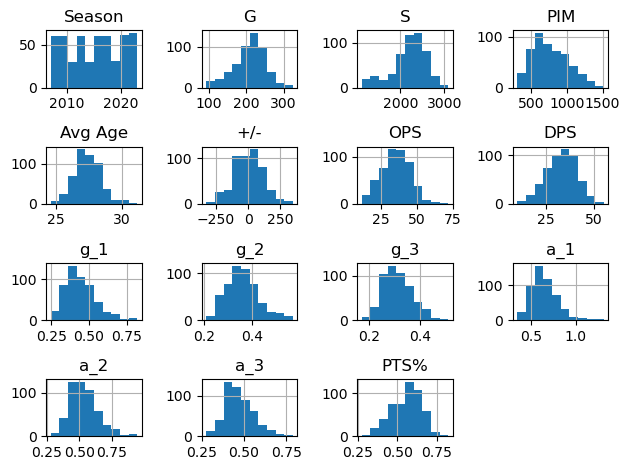

In [25]:
# Ensuring distributions still look acceptable for standard scaling and modeling
data.hist()
plt.tight_layout()
plt.show()

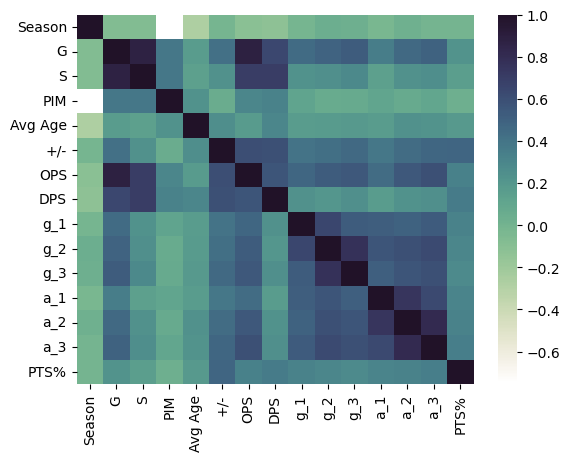

In [26]:
# Checking for collinearity. These features seem relatively independent.
sns.heatmap(data.corr(), cmap = sns.cubehelix_palette(start=.5, rot=-.75, dark = 0.1,
                                                               light = 1, as_cmap=True))
plt.show()

## Pre-Processing ##

### Scaling Data by Season ###
Scoring changes from year-to-year in the NHL, so it doesn't make sense to scale the data across all 17 seasons with the same scaler. Instead, I'll scale each season individually.

As a result, my prediction data will be scaled to their own 0 mean and unit variance. These will be the data for 2023. No data leakage can occur with this method of scaling.

I'm using a standard scaler because I believe outliers are not random in the context of NHL hockey and are important for predicting team success.

In [27]:
from sklearn.preprocessing import StandardScaler

scaled_data = data.copy()

scaler = StandardScaler()
seasons = scaled_data['Season'].unique()
scale_cols = ['G', 'S', 'PIM', 'Avg Age', '+/-', 'OPS', 'DPS',
       'g_1', 'g_2', 'g_3', 'a_1', 'a_2', 'a_3']

import warnings
warnings.filterwarnings('ignore')

for season in seasons:
    season_data = scaled_data[scaled_data['Season'] == season]
    season_data[scale_cols] = scaler.fit_transform(season_data[scale_cols])
    scaled_data[scaled_data['Season'] == season] = season_data

scaled_data

,Team,Season,G,S,PIM,Avg Age,+/-,OPS,DPS,g_1,g_2,g_3,a_1,a_2,a_3,PTS%
0,ANA,2007,-0.605309,-0.881020,0.460611,0.823991,0.481525,0.106321,0.051395,0.050374,0.442139,-1.069636,-0.690941,0.367093,1.109650,0.671
1,ANA,2008,0.296144,0.527733,1.774782,1.953661,0.965015,0.530684,1.741587,1.354650,-1.302998,-0.456800,-0.033857,1.082524,1.149676,0.622
2,ANA,2009,-1.237339,-0.834821,2.070816,0.979197,0.770374,-1.188494,0.826605,0.057543,0.853209,0.193382,0.896201,-1.121057,-0.585146,0.555
3,ANA,2010,0.073596,0.177957,2.494987,-0.661622,0.206050,0.730738,-0.156201,0.375422,0.871260,1.479170,1.590904,0.078996,0.668258,0.543
4,ANA,2011,-0.011798,-0.976886,0.938409,1.211791,-0.431106,0.121858,-1.606494,0.687950,1.057630,0.526731,0.879692,0.495844,-0.093101,0.604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,WSH,2019,0.724872,-0.089351,1.150340,0.384997,0.541332,0.472805,0.535205,1.969452,-0.373442,-1.140721,0.330251,0.865952,1.425630,0.634
514,WSH,2020,0.698714,-0.051405,1.577383,1.271994,1.026249,0.865081,0.241456,2.006702,-0.439712,0.133442,0.158744,0.846566,1.565484,0.652
515,WSH,2021,1.458860,1.173236,1.909645,3.160373,0.470736,1.335980,0.211076,2.103022,0.070182,0.708414,1.398573,1.092848,0.620417,0.688
516,WSH,2022,1.067226,-0.165799,0.369714,1.732495,0.237836,1.230135,-0.415067,0.858815,0.734338,-0.101995,0.195493,0.813927,0.447752,0.610


In [28]:
# Scaling 2024 data
scaled_24 = team_stats_24.copy()
scaler = StandardScaler()
scale_cols = ['G', 'S', 'PIM', 'Avg Age', '+/-', 'OPS', 'DPS',
       'g_1', 'g_2', 'g_3', 'a_1', 'a_2', 'a_3']

import warnings
warnings.filterwarnings('ignore')

scaled_24[scale_cols] = scaler.fit_transform(team_stats_24[scale_cols])

scaled_24.head()

,Team,Season,G,S,PIM,Avg Age,+/-,OPS,DPS,g_1,g_2,g_3,a_1,a_2,a_3
0,ANA,2024,-1.527132,-1.536135,0.923747,-0.817556,-1.559526,-1.537028,-2.043270,-1.187581,-0.821852,-0.873872,-0.876794,-0.586102,-0.685459
1,ARI,2024,0.004286,-0.636150,2.265051,-0.912345,-0.723971,-0.521517,-0.659998,-0.375234,-0.606637,0.084008,-0.544861,-0.023669,0.395758
2,BOS,2024,0.072857,-0.127587,0.268453,0.888648,2.024222,0.556902,1.434956,2.104115,0.178897,-0.812073,-0.098260,0.276295,0.986423
3,BUF,2024,1.032850,1.063821,-0.438036,-1.670658,-0.084249,0.979283,-0.269074,0.910981,0.867585,1.582625,0.336271,0.043823,0.636028
4,CAR,2024,-0.155713,1.029536,0.872552,0.793859,0.934084,-0.000281,1.735667,-1.306048,-1.349129,-1.831751,-0.991462,-0.548607,-0.885684


### Holdout Data ###
My final measure of success will be testing the model against the 2023 season results, so I'm holding that season out of training and testing.

In [29]:
X_hold = (scaled_data
          .loc[scaled_data['Season'] == 2023]
          .drop('PTS%', axis = 1)
          .set_index(['Season', 'Team'])
         )

y_hold = (scaled_data
          .loc[scaled_data['Season'] == 2023][['Team', 'Season', 'PTS%']]
          .set_index(['Season', 'Team'])
         )

# Drop 2023 from X and y
X = (scaled_data
     .drop('PTS%', axis = 1)
     .drop(scaled_data[scaled_data['Season'] == 2023].index)
     .reset_index(drop = True)
    )

y = (scaled_data[['Team', 'Season', 'PTS%']]
     .drop(scaled_data[scaled_data['Season'] == 2023].index)
     .reset_index(drop = True)
    )
# Create X and y for predicting 2024 playoff teams
X_all = (scaled_data
         .drop('PTS%', axis = 1)
         .set_index(['Season', 'Team'])
        )

y_all = (scaled_data[['Team', 'Season', 'PTS%']]
         .reset_index(drop = True)
         .set_index(['Season', 'Team'])
        )

X_24 = (scaled_24
        .set_index(['Season', 'Team'])
       )

In [31]:
X.to_csv('../data/processed/X.csv', index = False)
y.to_csv('../data/processed/y.csv', index = False)

X_hold.to_csv('../data/processed/X_hold.csv', index = True)
y_hold.to_csv('../data/processed/y_hold.csv', index = True)

X_all.to_csv('../data/processed/X_all.csv', index = True)
y_all.to_csv('../data/processed/y_all.csv', index = True)

X_24.to_csv('../data/processed/X_24.csv', index = True)

## Answer Key ##
In order to evaluate the predictions, I need to check whether the correct teams made the playoffs, not just their estimated points percentage. To do so, I need a key to compare against.

In [32]:
# Create a DataFrame with each team's playoffs status and points percentage for each season
playoff_column = pd.DataFrame(adjusted_team_df[['Team', 'Season', 'Playoffs']])
true_playoff_status = pd.merge(playoff_column, pts_pct, on = ['Team', 'Season'], how = 'inner')
teams_23 = true_playoff_status.loc[true_playoff_status['Season'] == 2023]['Team'].unique()
df_24 = pd.DataFrame({'Team': teams_23, 'Season': 2024, 'Playoffs': np.nan, 'PTS%': np.nan})
all_playoffs = pd.concat([true_playoff_status, df_24], ignore_index = True)
all_playoffs

,Team,Season,Playoffs,PTS%
0,ANA,2006,1.0,0.598
1,ARI,2006,0.0,0.494
2,BOS,2006,0.0,0.451
3,BUF,2006,1.0,0.671
4,CAR,2006,1.0,0.683
...,...,...,...,...
575,TOR,2024,NaN,NaN
576,VAN,2024,NaN,NaN
577,VEG,2024,NaN,NaN
578,WPG,2024,NaN,NaN


### Division and Conference Mapping ###
The NHL has restructured its divisions and conferences a number of times over the past few decades.They've also moved and added teams and changed the playoff entry criteria. I'll need a function that takes the points percentage as well as the team's conference and division into account to determine playoff status. To write this function, I'll need to be able to map teams to the appropriate divisions and conferences. I'll pass a list of mapping dictionaries into the function.

In [33]:
# Divisions and conferences until 2014
div_2006 = {
    ('NJD', 'NYI', 'NYR', 'PIT', 'PHI'): 'Atl',
    ('OTT', 'MTL', 'TOR', 'BUF', 'BOS'): 'NE',
    ('CAR', 'TBL', 'WPG', 'WSH', 'FLA'): 'SE',
    ('DET', 'CBJ', 'CHI', 'NSH', 'STL'): 'Cen',
    ('VAN', 'CGY', 'EDM', 'COL', 'MIN'): 'NW',
    ('DAL', 'SJS', 'LAK', 'ANA', 'ARI'): 'Pac'
    }

conf_2006 = {
    ('Atl', 'NE', 'SE'): 'East',
    ('Cen', 'NW', 'Pac'): 'West'
    }

# New structure (2 conferences, 4 divisions) started 2013-14.
div_2014 = {
    ('NJD', 'NYI', 'NYR', 'PIT', 'PHI', 'WSH', 'CAR', 'CBJ'): 'Met',
    ('OTT', 'MTL', 'TOR', 'BUF', 'BOS', 'TBL', 'FLA', 'DET'): 'Atl',
    ('CHI', 'NSH', 'STL', 'COL', 'MIN', 'WPG', 'DAL'): 'Cen',
    ('EDM', 'SJS', 'LAK', 'ANA', 'ARI', 'VAN', 'CGY', 'VEG'): 'Pac'
    }

conf_2014 = {
    ('Met', 'Atl'): 'East',
    ('Cen', 'Pac'): 'West'
    }
       
# 4 conferences in 2021
conf_2021 = {
    ('NJD', 'NYI', 'NYR', 'PIT', 'PHI', 'WSH', 'BOS', 'BUF'): 'East',
    ('CAR', 'TBL', 'FLA', 'CBJ', 'DET', 'NSH', 'CHI', 'DAL'): 'Central',
    ('TOR', 'MTL', 'OTT', 'WPG', 'EDM', 'CGY', 'VAN'): 'North',
    ('COL', 'VEG', 'ARI', 'LAK', 'ANA', 'SJS', 'MIN', 'STL'): 'West'
     }

# Vegas and Seattle in the Pacific moved Arizona to the Central. Same conferences as 2014.
div_2022 = {
    ('NJD', 'NYI', 'NYR', 'PIT', 'PHI', 'WSH', 'CAR', 'CBJ'): 'Met',
    ('OTT', 'MTL', 'TOR', 'BUF', 'BOS', 'TBL', 'FLA', 'DET'): 'Atl',
    ('CHI', 'NSH', 'STL', 'COL', 'MIN', 'WPG', 'DAL', 'ARI'): 'Cen',
    ('EDM', 'SJS', 'LAK', 'ANA', 'SEA', 'VAN', 'CGY', 'VEG'): 'Pac'
    }

map_dicts = [div_2006, conf_2006, div_2014, conf_2014, conf_2021, div_2022]

In [34]:
def create_answer_key(true_playoff_status, map_dicts):
    ''' (DataFrame, list of dicts) -> DataFrame
    Returns a DataFrame of each team's points percentage, 
    playoff status, division, and conference for each season.
    '''

    answer_key = (true_playoff_status
                  .copy()
                  .reindex(columns = ['Team', 'Season', 'Conf', 'Div', 'PTS%', 'Playoffs'])
                  .rename(columns = {'Playoffs': 'True_playoffs'})
                 )

    # I have to iterate over the rows to apply the correct map_dict
    for index, row in true_playoff_status.iterrows():
        team = row['Team']
        season = row['Season']

        div = None
        conf = None

        if season >= 2006 and season < 2014:
            for teams, division in div_2006.items():
                if team in teams:
                    div = division
                    for divisions, conference in conf_2006.items():
                        if div in divisions:
                            conf = conference
                            break
        
        elif season >= 2014 and season < 2021:
            for teams, division in div_2014.items():
                if team in teams:
                    div = division
                    for divisions, conference in conf_2014.items():
                        if div in divisions:
                            conf = conference
                            break
    
        elif season == 2021:
            for teams, conference in conf_2021.items():
                if team in teams:
                    conf = conference
                    div = conference
                    break
    
        elif season > 2021:
            for teams, division in div_2022.items():
                if team in teams:
                    div = division
                    for divisions, conference in conf_2014.items():
                        if div in divisions:
                            conf = conference
                            break
    

        # Updating the 'Div' and 'Conf' values for each row
        answer_key.at[index, 'Div'] = div
        answer_key.at[index, 'Conf'] = conf

        
    return answer_key

In [35]:
answer_key = create_answer_key(all_playoffs, map_dicts)
answer_key

,Team,Season,Conf,Div,PTS%,True_playoffs
0,ANA,2006,West,Pac,0.598,1.0
1,ARI,2006,West,Pac,0.494,0.0
2,BOS,2006,East,NE,0.451,0.0
3,BUF,2006,East,NE,0.671,1.0
4,CAR,2006,East,SE,0.683,1.0
...,...,...,...,...,...,...
575,TOR,2024,East,Atl,NaN,NaN
576,VAN,2024,West,Pac,NaN,NaN
577,VEG,2024,West,Pac,NaN,NaN
578,WPG,2024,West,Cen,NaN,NaN


### Playoff Function ###
Now that the teams are assigned to the correct divisions and conferences for each season of play, I need a way to check if their predicted points percentage corresponds with a playoff spot or not. 

In [36]:
def create_playoff_preds(y_score, answer_key):
    ''' (DataFrame, DataFrame) -> DataFrame

    Returns a DataFrame of predicted playoff standings and actual playoff standings from a 
    DataFrame of predicted points percentages and an "answer key" of conference and division
    alignments as well as actual points percentage and true playoff status.

    '''

    # Left merging the predictions with the answer key to just get the relevant portion
    y_eval = pd.merge(y_score.reset_index(drop = False), answer_key, on = ['Team', 'Season'], how = 'left')
    
    playoff_preds = pd.DataFrame()

    # Iterating over the seasons because playoff criteria have changed over time
    for season in y_eval['Season'].unique():
        
        season_view = y_eval.loc[y_eval['Season'] == season]

        # Each division leader and 5 conference wildcards made the playoffs until 2014
        if season < 2014:
            div_leaders = 1
            wild_cards = 5

        # The top 3 teams from each division and 2 conference wildcards make the playoffs nowadays
        elif season < 2020 or season > 2021:
            div_leaders = 3
            wild_cards = 2

        # Due to the abrupt stoppage of the 2020 season, the playoffs used the top 12 teams per conference
        elif season == 2020:
            div_leaders = 0
            wild_cards = 12

        # Due to the 4 separate conferences in 2021, the top 4 teams from each conference made the playoffs
        elif season == 2021:
            div_leaders = 0
            wild_cards = 4

        # Grabbing the division winners (none for 2020 and 2021)
        div_winners = pd.DataFrame(season_view
                           .set_index(['Team', 'Season'])
                           .groupby(['Conf', 'Div'])['PTS%_Pred']
                           .nlargest(div_leaders)
                           .reset_index(drop = False)
                           .assign(Pred_playoffs = 1)
                          )
        
        # Merging with the whole season will create a null value in the 'Pred_playoffs' column for division non-winners
        merged_df = season_view.merge(div_winners, how='left', on=['Team', 'Season', 'PTS%_Pred', 'Conf', 'Div'])
        non_winners_df = merged_df[merged_df['Pred_playoffs'].isnull()]

        # The remaining teams are selected as wildcards based on the criteria for a given year (all playoff teams for 2020 and 2021)
        wild_cards = pd.DataFrame(non_winners_df
                              .set_index(['Team', 'Season', 'Div'])
                               .groupby(['Conf'])['PTS%_Pred']
                               .nlargest(wild_cards)
                               .reset_index(drop = False)
                               .assign(Pred_playoffs = 1)
                              )
        
        # The list of playoff teams is established
        playoff_teams = pd.concat([div_winners, wild_cards])

        # Merge those teams with the rest of the standings and fill the remaining 'Pred_playoffs' null values with 0
        standings = (season_view
                     .merge(playoff_teams, how = 'left', on = ['Team', 'Season', 'PTS%_Pred', 'Conf', 'Div'])
                     .fillna(0)
                    )
        
        # Concatenate the overall playoff_preds DataFrame with this season's standings
        playoff_preds = pd.concat([playoff_preds, standings])

    return playoff_preds

## Next Steps ##
Modeling is the next step in this process. I'll evaluate the performance of a variety of model types to find which performs best.
I'll eventually use the model to predict 2024 season results too, but the season isn't even underway yet, so lineups are not finalized. I'm eager to see how this simple model performs.